## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

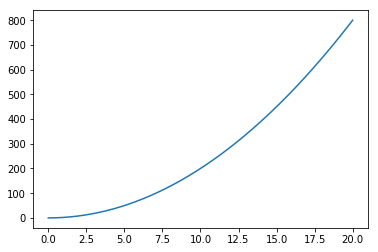

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 2, x.size)
z = np.linspace(0, 20, 10000)
deltaz = np.random.normal(0, 2, z.size)
y = 2 * x * z
x_prima = x + deltax
z_prima = z + deltaz
plt.plot(x,y)
plt.show()

Epoch 1/200
10000/10000 [==============================] - 0s - loss: 378676.5182 - mean_squared_error: 378676.5182   
Epoch 2/200
10000/10000 [==============================] - 0s - loss: 365278.5442 - mean_squared_error: 365278.5442   
Epoch 3/200
10000/10000 [==============================] - 0s - loss: 354244.5350 - mean_squared_error: 354244.5350   
Epoch 4/200
10000/10000 [==============================] - 0s - loss: 343766.7284 - mean_squared_error: 343766.7284   
Epoch 5/200
10000/10000 [==============================] - 0s - loss: 333658.4843 - mean_squared_error: 333658.4843   
Epoch 6/200
10000/10000 [==============================] - 0s - loss: 323849.0188 - mean_squared_error: 323849.0188   
Epoch 7/200
10000/10000 [==============================] - 0s - loss: 314302.8324 - mean_squared_error: 314302.8324   
Epoch 8/200
10000/10000 [==============================] - 0s - loss: 304997.7282 - mean_squared_error: 304997.7282   
Epoch 9/200
10000/10000 [=======================

10000/10000 [==============================] - 0s - loss: 21330.6642 - mean_squared_error: 21330.6642   
Epoch 70/200
10000/10000 [==============================] - 0s - loss: 20004.1472 - mean_squared_error: 20004.1472   
Epoch 71/200
10000/10000 [==============================] - 0s - loss: 18749.9242 - mean_squared_error: 18749.9242   
Epoch 72/200
10000/10000 [==============================] - 0s - loss: 17566.1091 - mean_squared_error: 17566.1091   
Epoch 73/200
10000/10000 [==============================] - 0s - loss: 16450.7429 - mean_squared_error: 16450.7429   
Epoch 74/200
10000/10000 [==============================] - 0s - loss: 15401.9162 - mean_squared_error: 15401.9162   
Epoch 75/200
10000/10000 [==============================] - 0s - loss: 14417.6273 - mean_squared_error: 14417.6273   
Epoch 76/200
10000/10000 [==============================] - 0s - loss: 13495.8554 - mean_squared_error: 13495.8554   
Epoch 77/200
10000/10000 [==============================] - 0s - loss

10000/10000 [==============================] - 0s - loss: 4249.7797 - mean_squared_error: 4249.7797     
Epoch 139/200
10000/10000 [==============================] - 0s - loss: 4249.8698 - mean_squared_error: 4249.8698     
Epoch 140/200
10000/10000 [==============================] - 0s - loss: 4249.9617 - mean_squared_error: 4249.9617     
Epoch 141/200
10000/10000 [==============================] - 0s - loss: 4250.0546 - mean_squared_error: 4250.0546     
Epoch 142/200
10000/10000 [==============================] - 0s - loss: 4250.1501 - mean_squared_error: 4250.1501     
Epoch 143/200
10000/10000 [==============================] - 0s - loss: 4250.2470 - mean_squared_error: 4250.2470     
Epoch 144/200
10000/10000 [==============================] - 0s - loss: 4250.3457 - mean_squared_error: 4250.3457     
Epoch 145/200
10000/10000 [==============================] - 0s - loss: 4250.4457 - mean_squared_error: 4250.4457     
Epoch 146/200
10000/10000 [==============================] - 0

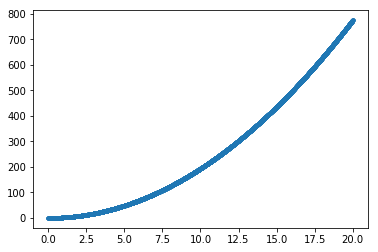

In [3]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds", use_bias=False)(product)

rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit([x_prima, z_prima], y, batch_size=128, epochs=200, shuffle=False)
raw_result = rawmodel.predict([x, z])
plt.plot(x, raw_result[:,0],'.')
plt.show()

In [4]:
rawmodel.layers[3].get_weights()

[array([[ 1.93669915]], dtype=float32)]

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output. Note that differently from the 1 input version, in this case the sigma is not squared. This is because the sigma here applied is the combination of the sigmas of the 2 inputs, each of them squared in the model

In [19]:
def aleatoric_loss(y_true, y_pred):
    sigma1 = y_pred[:, 1]
    sigma2 = y_pred[:, 2]
    sigmas = K.pow(K.square(K.pow(sigma1, -1)) + K.square(K.pow(sigma2, -1)),-1)
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (sigmas+ epsilon)) + K.log(sigmas + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

First we try a model without calculating the sigma and plot some results.

Then we try a model where the sigmas are computed. In this case we have two sigmas, on for each input, that share the same network. Sigmas are squared and combined, by adding them, as a resulting sigma that is train in the loss together with the mean squared error of the labels and the predictions.

In [20]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
sigma_hidden1 = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_hidden2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_output = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds", use_bias=False, weights=rawmodel.layers[3].get_weights())(product)
sigma1_hidden1 = sigma_hidden1(input1)
sigma1_hidden2 = sigma_hidden2(sigma1_hidden1)
sigma1 = sigma_output(sigma1_hidden2)
sigma2_hidden1 = sigma_hidden1(input2)
sigma2_hidden2 = sigma_hidden2(sigma2_hidden1)
sigma2 = sigma_output(sigma2_hidden2)
aleatoric_output = concatenate([preds, sigma1, sigma2])
model = Model(inputs=[input1,input2],outputs=aleatoric_output)
model.compile(optimizer=Adam(lr=0.0001), loss=aleatoric_loss, metrics=[aleatoric_rms])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 10)            20          input_11[0][0]                   
                                                                   input_12[0][0]                   
____________________________________________________________________________________________________
multiply_12 (Multiply)           (None, 1)             0           input_11[0][0]          

In [21]:
model.fit([x_prima, z_prima], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=1000, shuffle=False)

Epoch 1/1000
10000/10000 [==============================] - 0s - loss: 57013836.1088 - aleatoric_rms: 4245.1272     
Epoch 2/1000
10000/10000 [==============================] - 0s - loss: 12053338.4544 - aleatoric_rms: 4247.6551     
Epoch 3/1000
10000/10000 [==============================] - 0s - loss: 7006236.4328 - aleatoric_rms: 4249.2902     
Epoch 4/1000
10000/10000 [==============================] - 0s - loss: 4946172.0172 - aleatoric_rms: 4250.7703     
Epoch 5/1000
10000/10000 [==============================] - 0s - loss: 3729763.5464 - aleatoric_rms: 4252.1230     
Epoch 6/1000
10000/10000 [==============================] - 0s - loss: 2930841.5150 - aleatoric_rms: 4253.3690     
Epoch 7/1000
10000/10000 [==============================] - 0s - loss: 2371510.7708 - aleatoric_rms: 4254.5259     
Epoch 8/1000
10000/10000 [==============================] - 0s - loss: 1962033.1486 - aleatoric_rms: 4255.6056     
Epoch 9/1000
10000/10000 [==============================] - 0s - loss:

10000/10000 [==============================] - 0s - loss: 11451.4752 - aleatoric_rms: 4294.6501     
Epoch 72/1000
10000/10000 [==============================] - 0s - loss: 10802.3568 - aleatoric_rms: 4294.5675     
Epoch 73/1000
10000/10000 [==============================] - 0s - loss: 10198.1407 - aleatoric_rms: 4294.4568     
Epoch 74/1000
10000/10000 [==============================] - 0s - loss: 9633.6330 - aleatoric_rms: 4294.3271     
Epoch 75/1000
10000/10000 [==============================] - 0s - loss: 9104.7128 - aleatoric_rms: 4294.1822     
Epoch 76/1000
10000/10000 [==============================] - 0s - loss: 8608.0474 - aleatoric_rms: 4294.0211     
Epoch 77/1000
10000/10000 [==============================] - 0s - loss: 8140.9430 - aleatoric_rms: 4293.8482     
Epoch 78/1000
10000/10000 [==============================] - 0s - loss: 7701.0889 - aleatoric_rms: 4293.6660     
Epoch 79/1000
10000/10000 [==============================] - 0s - loss: 7286.5053 - aleatoric_rms: 

10000/10000 [==============================] - 0s - loss: 237.2640 - aleatoric_rms: 4289.7504     
Epoch 143/1000
10000/10000 [==============================] - 0s - loss: 225.0599 - aleatoric_rms: 4289.8094     
Epoch 144/1000
10000/10000 [==============================] - 0s - loss: 213.5093 - aleatoric_rms: 4289.8703     
Epoch 145/1000
10000/10000 [==============================] - 0s - loss: 202.5774 - aleatoric_rms: 4289.9329     
Epoch 146/1000
10000/10000 [==============================] - 0s - loss: 192.2264 - aleatoric_rms: 4289.9969     
Epoch 147/1000
10000/10000 [==============================] - 0s - loss: 182.4265 - aleatoric_rms: 4290.0623     
Epoch 148/1000
10000/10000 [==============================] - 0s - loss: 173.1522 - aleatoric_rms: 4290.1278     
Epoch 149/1000
10000/10000 [==============================] - 0s - loss: 164.3630 - aleatoric_rms: 4290.1919     
Epoch 150/1000
10000/10000 [==============================] - 0s - loss: 156.0457 - aleatoric_rms: 4290

10000/10000 [==============================] - 1s - loss: 12.2369 - aleatoric_rms: 4296.4643     
Epoch 215/1000
10000/10000 [==============================] - 0s - loss: 12.0078 - aleatoric_rms: 4296.6221     
Epoch 216/1000
10000/10000 [==============================] - 0s - loss: 11.7919 - aleatoric_rms: 4296.7827     
Epoch 217/1000
10000/10000 [==============================] - 0s - loss: 11.5888 - aleatoric_rms: 4296.9458     
Epoch 218/1000
10000/10000 [==============================] - 0s - loss: 11.3977 - aleatoric_rms: 4297.1127     
Epoch 219/1000
10000/10000 [==============================] - 0s - loss: 11.2180 - aleatoric_rms: 4297.2816     
Epoch 220/1000
10000/10000 [==============================] - 0s - loss: 11.0490 - aleatoric_rms: 4297.4560     
Epoch 221/1000
10000/10000 [==============================] - 0s - loss: 10.8903 - aleatoric_rms: 4297.6339     
Epoch 222/1000
10000/10000 [==============================] - 0s - loss: 10.7413 - aleatoric_rms: 4297.8155    

10000/10000 [==============================] - 0s - loss: 8.7927 - aleatoric_rms: 4320.5869     
Epoch 288/1000
10000/10000 [==============================] - 0s - loss: 8.7916 - aleatoric_rms: 4320.7799     
Epoch 289/1000
10000/10000 [==============================] - 0s - loss: 8.7906 - aleatoric_rms: 4320.9612     
Epoch 290/1000
10000/10000 [==============================] - 0s - loss: 8.7896 - aleatoric_rms: 4321.1293     
Epoch 291/1000
10000/10000 [==============================] - 0s - loss: 8.7887 - aleatoric_rms: 4321.2869     
Epoch 292/1000
10000/10000 [==============================] - 0s - loss: 8.7879 - aleatoric_rms: 4321.4339     
Epoch 293/1000
10000/10000 [==============================] - 0s - loss: 8.7871 - aleatoric_rms: 4321.5668     
Epoch 294/1000
10000/10000 [==============================] - 0s - loss: 8.7864 - aleatoric_rms: 4321.6910     
Epoch 295/1000
10000/10000 [==============================] - 0s - loss: 8.7857 - aleatoric_rms: 4321.8067     
Epoch 2

10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.6831     
Epoch 360/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.6963     
Epoch 361/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.7099     
Epoch 362/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.7245     
Epoch 363/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.7391     
Epoch 364/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.7531     
Epoch 365/1000
10000/10000 [==============================] - 0s - loss: 8.7764 - aleatoric_rms: 4323.7667     
Epoch 366/1000
10000/10000 [==============================] - 0s - loss: 8.7763 - aleatoric_rms: 4323.7819     
Epoch 367/1000
10000/10000 [==============================] - 0s - loss: 8.7763 - aleatoric_rms: 4323.7951     
Epoch 3

10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.6935     
Epoch 433/1000
10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.7053     
Epoch 434/1000
10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.7180     
Epoch 435/1000
10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.7315     
Epoch 436/1000
10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.7453     
Epoch 437/1000
10000/10000 [==============================] - 0s - loss: 8.7760 - aleatoric_rms: 4324.7597     
Epoch 438/1000
10000/10000 [==============================] - 0s - loss: 8.7759 - aleatoric_rms: 4324.7742     
Epoch 439/1000
10000/10000 [==============================] - 0s - loss: 8.7759 - aleatoric_rms: 4324.7882     
Epoch 440/1000
10000/10000 [==============================] - 0s - loss: 8.7759 - aleatoric_rms: 4324.8024     
Epoch 4

10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.5800     
Epoch 506/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.5910     
Epoch 507/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6023     
Epoch 508/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6144     
Epoch 509/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6268     
Epoch 510/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6371     
Epoch 511/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6463     
Epoch 512/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6559     
Epoch 513/1000
10000/10000 [==============================] - 0s - loss: 8.7757 - aleatoric_rms: 4325.6646     
Epoch 5

10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2319     
Epoch 579/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2389     
Epoch 580/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2454     
Epoch 581/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2520     
Epoch 582/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2587     
Epoch 583/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2669     
Epoch 584/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2750     
Epoch 585/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2832     
Epoch 586/1000
10000/10000 [==============================] - 0s - loss: 8.7756 - aleatoric_rms: 4326.2918     
Epoch 5

10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7388     
Epoch 652/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7472     
Epoch 653/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7558     
Epoch 654/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7641     
Epoch 655/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7721     
Epoch 656/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7799     
Epoch 657/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7883     
Epoch 658/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.7960     
Epoch 659/1000
10000/10000 [==============================] - 0s - loss: 8.7754 - aleatoric_rms: 4326.8041     
Epoch 6

10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2172     
Epoch 725/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2238     
Epoch 726/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2310     
Epoch 727/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2388     
Epoch 728/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2467     
Epoch 729/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2541     
Epoch 730/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2615     
Epoch 731/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2694     
Epoch 732/1000
10000/10000 [==============================] - 0s - loss: 8.7753 - aleatoric_rms: 4327.2774     
Epoch 7

10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6262     
Epoch 798/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6306     
Epoch 799/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6344     
Epoch 800/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6379     
Epoch 801/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6418     
Epoch 802/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6457     
Epoch 803/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6493     
Epoch 804/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6532     
Epoch 805/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.6574     
Epoch 8

10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9385     
Epoch 871/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9428     
Epoch 872/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9471     
Epoch 873/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9511     
Epoch 874/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9556     
Epoch 875/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9609     
Epoch 876/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9664     
Epoch 877/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9721     
Epoch 878/1000
10000/10000 [==============================] - 0s - loss: 8.7752 - aleatoric_rms: 4327.9771     
Epoch 8

10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2287     
Epoch 944/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2330     
Epoch 945/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2370     
Epoch 946/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2409     
Epoch 947/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2445     
Epoch 948/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2484     
Epoch 949/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2522     
Epoch 950/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2557     
Epoch 951/1000
10000/10000 [==============================] - 0s - loss: 8.7751 - aleatoric_rms: 4328.2592     
Epoch 9

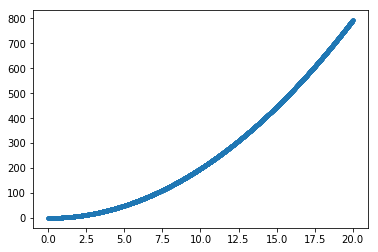

In [22]:
result = model.predict([x,z])
plt.plot(x, result[:,0],'.')
plt.show()

Here we plot the two sigmas. As we can see, the sigma for the first variable though for the second one the predicted sigma is quite wrong.

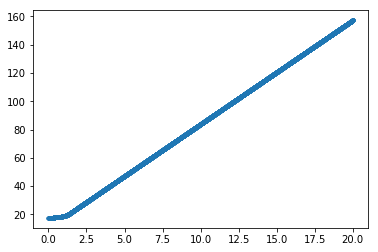

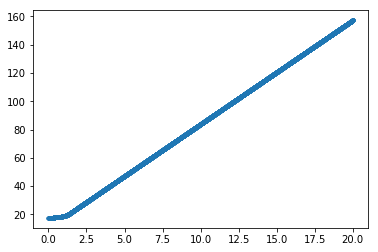

In [23]:
model_sigmas_x = Model(inputs=[input1], outputs=sigma1)
sigmas_x = model_sigmas_x.predict(x)
sigmas_x
plt.plot(x, np.abs(sigmas_x),'.')
plt.show()
model_sigmas_z = Model(inputs=[input2], outputs=sigma2)
sigmas_z = model_sigmas_z.predict(z)
sigmas_z
plt.plot(z, np.abs(sigmas_z),'.')
plt.show()

In [10]:
model.layers[8].get_weights()

[array([[ 1.9778775]], dtype=float32)]